In [1]:
# Imports
import os
import torch
import shutil
import numpy as np
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


In [2]:
import os
import tarfile
import urllib.request

# Create dir if needed
if not os.path.exists("food-101.tar.gz"):
    print("Downloading Food-101...")
    urllib.request.urlretrieve(
        "http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz", 
        "food-101.tar.gz"
    )
else:
    print("food-101.tar.gz already exists.")

# Unpack
if not os.path.exists("food-101/images"):
    print("Unpacking...")
    with tarfile.open("food-101.tar.gz") as tar:
        tar.extractall()
    print("Unpacked.")
else:
    print("'food-101/images' already exists.")

food-101.tar.gz already exists.
'food-101/images' already exists.


In [3]:
# Classes and paths
selected_classes = [
    'pizza', 'sushi', 'hamburger', 'spaghetti_bolognese', 'cheesecake',
    'greek_salad', 'tacos', 'donuts', 'pancakes', 'chicken_curry'
]

original_images_dir = 'food-101/images'
new_base_dir = 'food-10'

In [4]:
# Create train/val/test split

shutil.rmtree(new_base_dir, ignore_errors=True)

# Create base folders
for split in ['train', 'val', 'test']:
    for class_name in selected_classes:
        os.makedirs(os.path.join(new_base_dir, split, class_name), exist_ok=True)

def copy_images(class_name, split, images):
    for img in images:
        if img.lower().endswith('.jpg'):
            src = os.path.join(original_images_dir, class_name, img)
            dst = os.path.join(new_base_dir, split, class_name, img)
            if os.path.exists(src):
                shutil.copyfile(src, dst)

for class_name in selected_classes:
    class_dir = os.path.join(original_images_dir, class_name)
    if not os.path.exists(class_dir):
        print(f"Missing folder: {class_dir}")
        continue

    images = [img for img in os.listdir(class_dir) if img.lower().endswith('.jpg')]
    print(f"{class_name}: {len(images)} .jpg files found")

    train_and_val, test = train_test_split(images, test_size=0.15, random_state=42)
    train, val = train_test_split(train_and_val, test_size=0.1765, random_state=42)  # ≈15%

    copy_images(class_name, 'train', train)
    copy_images(class_name, 'val', val)
    copy_images(class_name, 'test', test)

pizza: 1000 .jpg files found
sushi: 1000 .jpg files found
hamburger: 1000 .jpg files found
spaghetti_bolognese: 1000 .jpg files found
cheesecake: 1000 .jpg files found
greek_salad: 1000 .jpg files found
tacos: 1000 .jpg files found
donuts: 1000 .jpg files found
pancakes: 1000 .jpg files found
chicken_curry: 1000 .jpg files found


In [5]:
# Transforms
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [7]:
# Datasets and Loaders
train_dataset = datasets.ImageFolder(os.path.join(new_base_dir, 'train'), transform=train_transforms)
val_dataset = datasets.ImageFolder(os.path.join(new_base_dir, 'val'), transform=test_transforms)
test_dataset = datasets.ImageFolder(os.path.join(new_base_dir, 'test'), transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

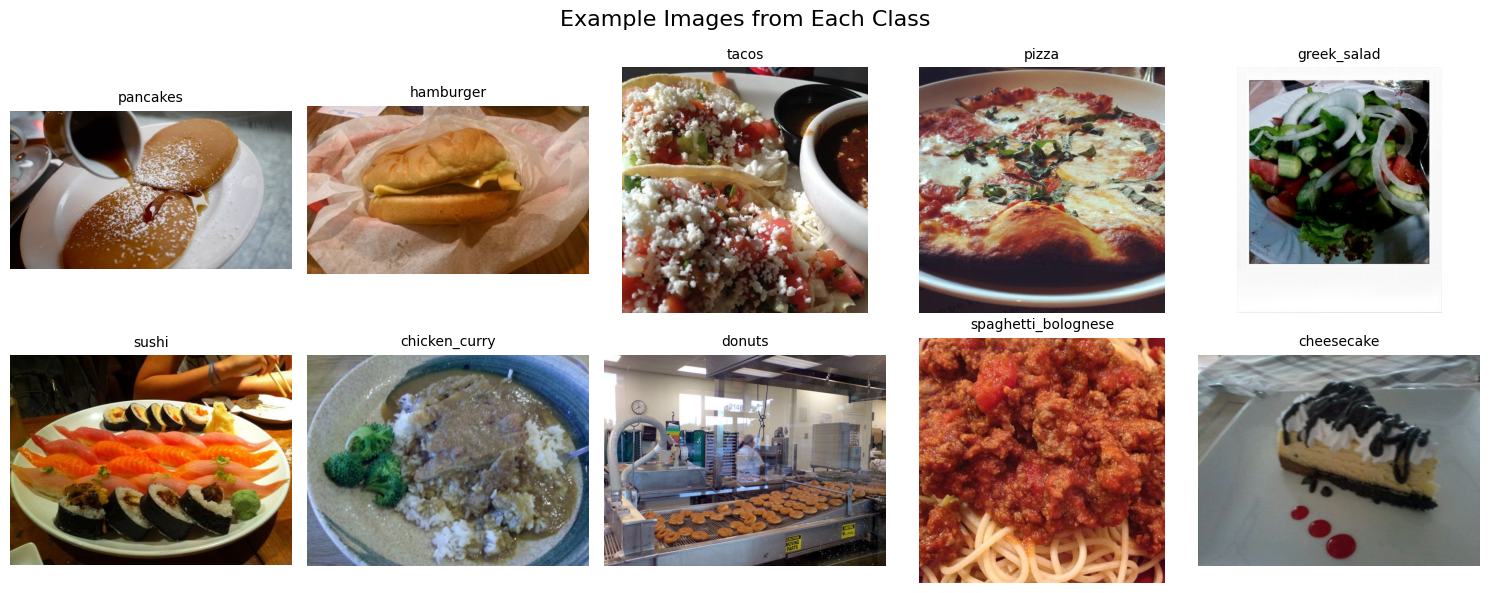

In [51]:
import matplotlib.pyplot as plt
import random
import os
from PIL import Image

# Show 1 random image per class
def show_class_examples(dataset, class_names, num_classes=10):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    fig.suptitle("Example Images from Each Class", fontsize=16)

    shown = set()
    for ax in axes.flatten():
        while True:
            idx = random.randint(0, len(dataset.samples) - 1)
            path, label = dataset.samples[idx]
            if label not in shown:
                shown.add(label)
                break
        img = Image.open(path).convert("RGB")
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(class_names[label], fontsize=10)

    plt.tight_layout()
    plt.show()

# Call the function
show_class_examples(train_dataset, train_dataset.classes)

In [8]:
# Training functions
def train_one_epoch(model, dataloader, criterion, optimizer):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for images, labels in tqdm(dataloader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return total_loss / total, correct / total

def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return total_loss / total, correct / total

In [9]:
# Train baseline model
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(selected_classes))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
best_val_acc = 0

for epoch in range(5):  # or 10 for full training
    print(f"\nEpoch {epoch+1}")
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    print(f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print("Best model saved.")

C:\Users\maria\anaconda3\envs\torch_gpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\maria\anaconda3\envs\torch_gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch 1


Validation: 100%|███| 48/48 [00:14<00:00,  3.21it/s]


Train Acc: 0.7273, Val Acc: 0.8623
Best model saved.

Epoch 2


Validation: 100%|███| 48/48 [00:14<00:00,  3.25it/s]


Train Acc: 0.8219, Val Acc: 0.8669
Best model saved.

Epoch 3


Validation: 100%|███| 48/48 [00:14<00:00,  3.25it/s]


Train Acc: 0.8526, Val Acc: 0.8921
Best model saved.

Epoch 4


Validation: 100%|███| 48/48 [00:15<00:00,  3.11it/s]


Train Acc: 0.8652, Val Acc: 0.8801

Epoch 5


Validation: 100%|███| 48/48 [00:15<00:00,  3.13it/s]

Train Acc: 0.8780, Val Acc: 0.8808


## Label Flipping Attack

In [10]:
# Label Flipping Attack
from copy import deepcopy

# Copy clean train_dataset to poisoned version
poisoned_dataset = deepcopy(train_dataset)

# Set source and target class
source_class = 'sushi'
target_class = 'pizza'
flip_ratio = 0.1  # 10% poisoned

# Class indices
source_idx = train_dataset.class_to_idx[source_class]
target_idx = train_dataset.class_to_idx[target_class]

# Get indices of source class samples
poisoned_indices = [i for i, (_, label) in enumerate(train_dataset.samples) if label == source_idx]

# How many to flip
num_poisoned = int(len(poisoned_indices) * flip_ratio)
print(f"Poisoning {num_poisoned} samples: '{source_class}' → '{target_class}'")

# Change labels
for i in poisoned_indices[:num_poisoned]:
    img_path, _ = poisoned_dataset.samples[i]
    poisoned_dataset.samples[i] = (img_path, target_idx)

Poisoning 69 samples: 'sushi' → 'pizza'


In [11]:
# Train on poisoned dataset
poisoned_loader = DataLoader(poisoned_dataset, batch_size=32, shuffle=True)

poisoned_model = models.resnet50(pretrained=True)
poisoned_model.fc = nn.Linear(poisoned_model.fc.in_features, len(selected_classes))
poisoned_model = poisoned_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(poisoned_model.parameters(), lr=1e-4)

for epoch in range(5):
    print(f"\n[Poisoned Model] Epoch {epoch+1}")
    train_loss, train_acc = train_one_epoch(poisoned_model, poisoned_loader, criterion, optimizer)
    val_loss, val_acc = evaluate(poisoned_model, val_loader, criterion)
    print(f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

# Save model for later
torch.save(poisoned_model.state_dict(), 'poisoned_model.pth')


[Poisoned Model] Epoch 1


Validation: 100%|███| 48/48 [00:14<00:00,  3.23it/s]


Train Acc: 0.7235, Val Acc: 0.8583

[Poisoned Model] Epoch 2


Validation: 100%|███| 48/48 [00:14<00:00,  3.22it/s]


Train Acc: 0.8187, Val Acc: 0.8775

[Poisoned Model] Epoch 3


Validation: 100%|███| 48/48 [00:14<00:00,  3.21it/s]


Train Acc: 0.8474, Val Acc: 0.8841

[Poisoned Model] Epoch 4


Validation: 100%|███| 48/48 [00:15<00:00,  3.09it/s]


Train Acc: 0.8625, Val Acc: 0.8841

[Poisoned Model] Epoch 5


Validation: 100%|███| 48/48 [00:14<00:00,  3.24it/s]


Train Acc: 0.8641, Val Acc: 0.8815


## FGSM - Fast Gragient Sign Method

In [12]:
# functions

def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    return torch.clamp(perturbed_image, -1, 1)  # normalized to [-1, 1]
def evaluate_fgsm(model, dataloader, epsilon):
    model.eval()
    correct = 0
    total = 0

    for data, target in tqdm(dataloader, desc=f"FGSM ε={epsilon}"):
        data, target = data.to(device), target.to(device)
        data.requires_grad = True

        output = model(data)
        loss = criterion(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        output = model(perturbed_data)
        final_pred = output.max(1, keepdim=True)[1]

        correct += final_pred.eq(target.view_as(final_pred)).sum().item()
        total += data.size(0)

    acc = correct / total
    print(f"FGSM ε={epsilon} → Accuracy: {acc:.4f}")
    return acc

In [13]:
# run with different epsilons
fgsm_epsilons = [0.0, 0.01, 0.05, 0.1]
fgsm_results = []

for eps in fgsm_epsilons:
    acc = evaluate_fgsm(poisoned_model, test_loader, epsilon=eps)
    fgsm_results.append((eps, acc))

FGSM ε=0.0: 100%|███| 47/47 [00:24<00:00,  1.88it/s]


FGSM ε=0.0 → Accuracy: 0.8880


FGSM ε=0.01: 100%|██| 47/47 [00:24<00:00,  1.94it/s]


FGSM ε=0.01 → Accuracy: 0.1413


FGSM ε=0.05: 100%|██| 47/47 [00:24<00:00,  1.94it/s]


FGSM ε=0.05 → Accuracy: 0.0647


FGSM ε=0.1: 100%|███| 47/47 [00:24<00:00,  1.95it/s]

FGSM ε=0.1 → Accuracy: 0.0867


## DeepFool

In [14]:
# Recreate the baseline model
baseline_model = models.resnet50(pretrained=True)
baseline_model.fc = nn.Linear(baseline_model.fc.in_features, len(selected_classes))
baseline_model.load_state_dict(torch.load('best_model.pth'))
baseline_model = baseline_model.to(device)
baseline_model.eval()

print("Baseline model loaded (best_model.pth)")

# Recreate the poisoned model
poisoned_model = models.resnet50(pretrained=True)
poisoned_model.fc = nn.Linear(poisoned_model.fc.in_features, len(selected_classes))
poisoned_model.load_state_dict(torch.load('poisoned_model.pth'))
poisoned_model = poisoned_model.to(device)
poisoned_model.eval()

print("Poisoned model loaded (poisoned_model.pth)")

Baseline model loaded (best_model.pth)


In [16]:
# setup and run
import torchattacks

deepfool = torchattacks.DeepFool(poisoned_model, steps=50)

def evaluate_deepfool(model, dataloader, attack):
    model.eval()
    correct, total = 0, 0

    for images, labels in tqdm(dataloader, desc="DeepFool"):
        images, labels = images.to(device), labels.to(device)
        adv_images = attack(images, labels)

        outputs = model(adv_images)
        preds = outputs.argmax(dim=1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    print(f"DeepFool → Accuracy: {acc:.4f}")
    return acc

deepfool_acc = evaluate_deepfool(poisoned_model, test_loader, deepfool)

DeepFool: 100%|█████| 47/47 [34:17<00:00, 43.77s/it]

DeepFool → Accuracy: 0.1580


## Attacks Summary

In [24]:
# function
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_metrics(model, dataloader, attack=None, epsilon=None, name='', max_batches=None):
    model.eval()
    y_true, y_pred = [], []

    print(f"\nEvaluating: {name} {'(FGSM ε=' + str(epsilon) + ')' if attack=='fgsm' else ''}")
    print("Processing batches...")

    for batch_idx, (images, labels) in enumerate(dataloader):
        if max_batches is not None and batch_idx >= max_batches:
            break

        print(f"  → Batch {batch_idx + 1}")

        images, labels = images.to(device), labels.to(device)

        if attack == 'fgsm' and epsilon is not None:
            images.requires_grad = True
            outputs = model(images)
            loss = criterion(outputs, labels)
            model.zero_grad()
            loss.backward()
            data_grad = images.grad.data
            images = fgsm_attack(images, epsilon, data_grad)

        elif attack == 'deepfool':
            print(f"     Running DeepFool on batch {batch_idx+1}...")
            images = deepfool(images, labels)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

    print(f"Done: {name}\n")
    return {
        'Name': name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, average='macro', zero_division=0),
        'Recall': recall_score(y_true, y_pred, average='macro', zero_division=0),
        'F1-score': f1_score(y_true, y_pred, average='macro', zero_division=0),
    }

In [25]:
# Clean + Poisoned + Attacks (subset of test set)

metrics_all = []

# Clean model
baseline_model = models.resnet50(pretrained=True)
baseline_model.fc = nn.Linear(baseline_model.fc.in_features, len(selected_classes))
baseline_model.load_state_dict(torch.load('best_model.pth'))
baseline_model = baseline_model.to(device)
baseline_model.eval()

metrics_all.append(evaluate_metrics(baseline_model, test_loader, name='Clean', max_batches=5))

# Poisoned model
metrics_all.append(evaluate_metrics(poisoned_model, test_loader, name='Poisoned', max_batches=5))

# FGSM (3 different ε)
for eps in [0.01, 0.05, 0.1]:
    metrics_all.append(
        evaluate_metrics(poisoned_model, test_loader, attack='fgsm', epsilon=eps, name=f'FGSM ε={eps}', max_batches=5)
    )

# DeepFool (limited)
metrics_all.append(
    evaluate_metrics(poisoned_model, test_loader, attack='deepfool', name='DeepFool', max_batches=5)
)

C:\Users\maria\anaconda3\envs\torch_gpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\maria\anaconda3\envs\torch_gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Evaluating: Clean 
Processing batches...
  → Batch 1
  → Batch 2
  → Batch 3
  → Batch 4
  → Batch 5
Done: Clean


Evaluating: Poisoned 
Processing batches...
  → Batch 1
  → Batch 2
  → Batch 3
  → Batch 4
  → Batch 5
Done: Poisoned


Evaluating: FGSM ε=0.01 (FGSM ε=0.01)
Processing batches...
  → Batch 1
  → Batch 2
  → Batch 3
  → Batch 4
  → Batch 5
Done: FGSM ε=0.01


Evaluating: FGSM ε=0.05 (FGSM ε=0.05)
Processing batches...
  → Batch 1
  → Batch 2
  → Batch 3
  → Batch 4
  → Batch 5
Done: FGSM ε=0.05


Evaluating: FGSM ε=0.1 (FGSM ε=0.1)
Processing batches...
  → Batch 1
  → Batch 2
  → Batch 3
  → Batch 4
  → Batch 5
Done: FGSM ε=0.1


Evaluating: DeepFool 
Processing batches...
  → Batch 1
     Running DeepFool on batch 1...
  → Batch 2
     Running DeepFool on batch 2...
  → Batch 3
     Running DeepFool on batch 3...
  → Batch 4
     Running DeepFool on batch 4...
  → Batch 5
     Running DeepFool on batch 5...
Done: DeepFool



,Accuracy,Precision,Recall,F1-score
Name,,,,
Clean,0.90000,0.285714,0.257143,0.270677
Poisoned,0.80625,0.222222,0.188889,0.204029
FGSM ε=0.01,0.06875,0.108182,0.026000,0.030298
FGSM ε=0.05,0.04375,0.102381,0.014000,0.020143
FGSM ε=0.1,0.10625,0.141612,0.022963,0.038385
DeepFool,0.14375,0.079310,0.015333,0.025698


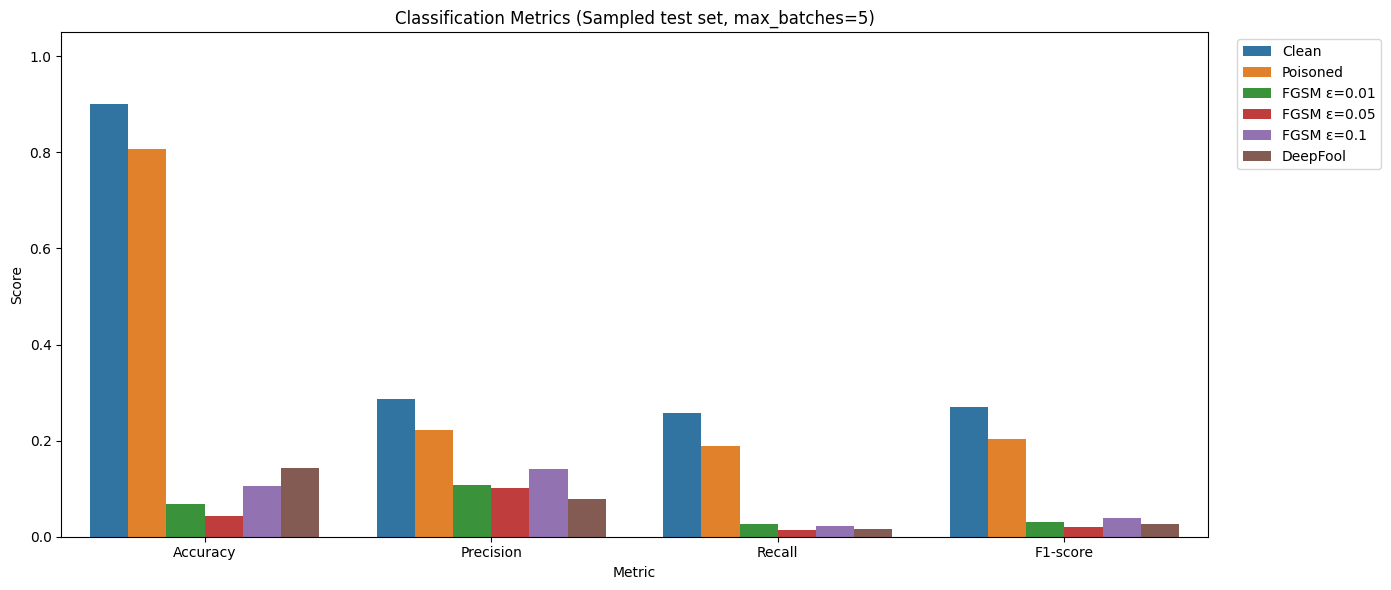

In [27]:
from IPython.display import display
import pandas as pd

# Convert to DataFrame
df_metrics = pd.DataFrame(metrics_all)
display(df_metrics.set_index('Name'))

# Prepare for barplot
df_melt = df_metrics.melt(id_vars='Name', var_name='Metric', value_name='Score')

# Plot
plt.figure(figsize=(14, 6))
sns.barplot(data=df_melt, x='Metric', y='Score', hue='Name')
plt.title('Classification Metrics (Sampled test set, max_batches=5)')
plt.ylim(0, 1.05)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Defense
## 1. Isolation Forest → Cleaning → Retraining → Comparison

In [28]:
# Feature extractor from ResNet-50 (without classificator)
feature_extractor = models.resnet50(pretrained=True)
feature_extractor.fc = nn.Identity()
feature_extractor = feature_extractor.to(device)
feature_extractor.eval()

raw_poisoned_loader = DataLoader(poisoned_dataset, batch_size=32, shuffle=False)
features = []
labels = []

with torch.no_grad():
    for images, lbls in tqdm(raw_poisoned_loader, desc="Extracting features"):
        images = images.to(device)
        feats = feature_extractor(images)
        features.append(feats.cpu())
        labels.extend(lbls.numpy())

features = torch.cat(features).numpy()
labels = np.array(labels)

C:\Users\maria\anaconda3\envs\torch_gpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\maria\anaconda3\envs\torch_gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Extracting features: 100%|█| 219/219 [05:38<00:00,  


In [29]:
# Apply Isolation forest
from sklearn.ensemble import IsolationForest

isf = IsolationForest(contamination=0.1, random_state=42)  # 10% of poison
preds = isf.fit_predict(features)

print("Outliers detected:", np.sum(preds == -1))
print("Clean samples kept:", np.sum(preds == 1))

# Filter the cleaned dataset
from torch.utils.data import Subset

clean_indices = np.where(preds == 1)[0]
cleaned_dataset = Subset(poisoned_dataset, clean_indices)
cleaned_loader = DataLoader(cleaned_dataset, batch_size=32, shuffle=True)

print("Cleaned dataset size:", len(cleaned_dataset))

Outliers detected: 699
Clean samples kept: 6291
Cleaned dataset size: 6291


In [30]:
# Train model on cleaned data
cleaned_model = models.resnet50(pretrained=True)
cleaned_model.fc = nn.Linear(cleaned_model.fc.in_features, len(selected_classes))
cleaned_model = cleaned_model.to(device)

optimizer = optim.Adam(cleaned_model.parameters(), lr=1e-4)

for epoch in range(5):
    print(f"\n[Cleaned Model] Epoch {epoch+1}")
    train_loss, train_acc = train_one_epoch(cleaned_model, cleaned_loader, criterion, optimizer)
    val_loss, val_acc = evaluate(cleaned_model, val_loader, criterion)
    print(f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

torch.save(cleaned_model.state_dict(), 'cleaned_model.pth')

C:\Users\maria\anaconda3\envs\torch_gpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\maria\anaconda3\envs\torch_gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



[Cleaned Model] Epoch 1


Validation: 100%|███| 48/48 [00:42<00:00,  1.12it/s]


Train Acc: 0.7234, Val Acc: 0.8642

[Cleaned Model] Epoch 2


Validation: 100%|███| 48/48 [00:41<00:00,  1.15it/s]


Train Acc: 0.8134, Val Acc: 0.8682

[Cleaned Model] Epoch 3


Validation: 100%|███| 48/48 [00:42<00:00,  1.12it/s]


Train Acc: 0.8531, Val Acc: 0.8344

[Cleaned Model] Epoch 4


Validation: 100%|███| 48/48 [00:41<00:00,  1.15it/s]


Train Acc: 0.8598, Val Acc: 0.8675

[Cleaned Model] Epoch 5


Validation: 100%|███| 48/48 [00:41<00:00,  1.15it/s]


Train Acc: 0.8747, Val Acc: 0.8881



Evaluating: Cleaned w/ IsolationForest 
Processing batches...
  → Batch 1
  → Batch 2
  → Batch 3
  → Batch 4
  → Batch 5
  → Batch 6
  → Batch 7
  → Batch 8
  → Batch 9
  → Batch 10
  → Batch 11
  → Batch 12
  → Batch 13
  → Batch 14
  → Batch 15
  → Batch 16
  → Batch 17
  → Batch 18
  → Batch 19
  → Batch 20
  → Batch 21
  → Batch 22
  → Batch 23
  → Batch 24
  → Batch 25
  → Batch 26
  → Batch 27
  → Batch 28
  → Batch 29
  → Batch 30
  → Batch 31
  → Batch 32
  → Batch 33
  → Batch 34
  → Batch 35
  → Batch 36
  → Batch 37
  → Batch 38
  → Batch 39
  → Batch 40
  → Batch 41
  → Batch 42
  → Batch 43
  → Batch 44
  → Batch 45
  → Batch 46
  → Batch 47
Done: Cleaned w/ IsolationForest



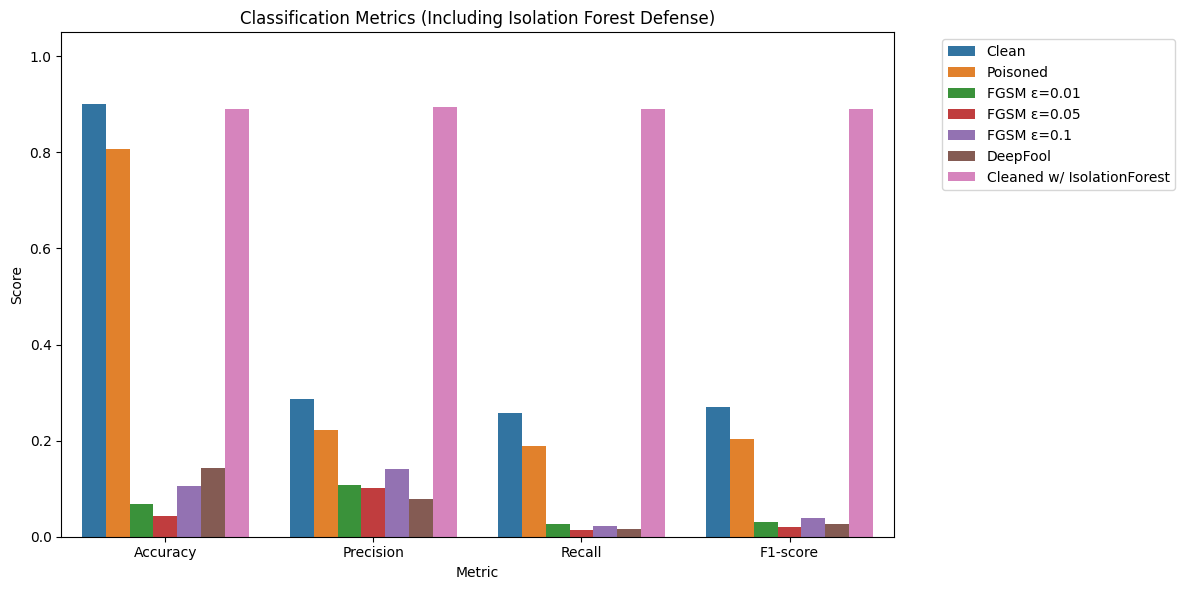

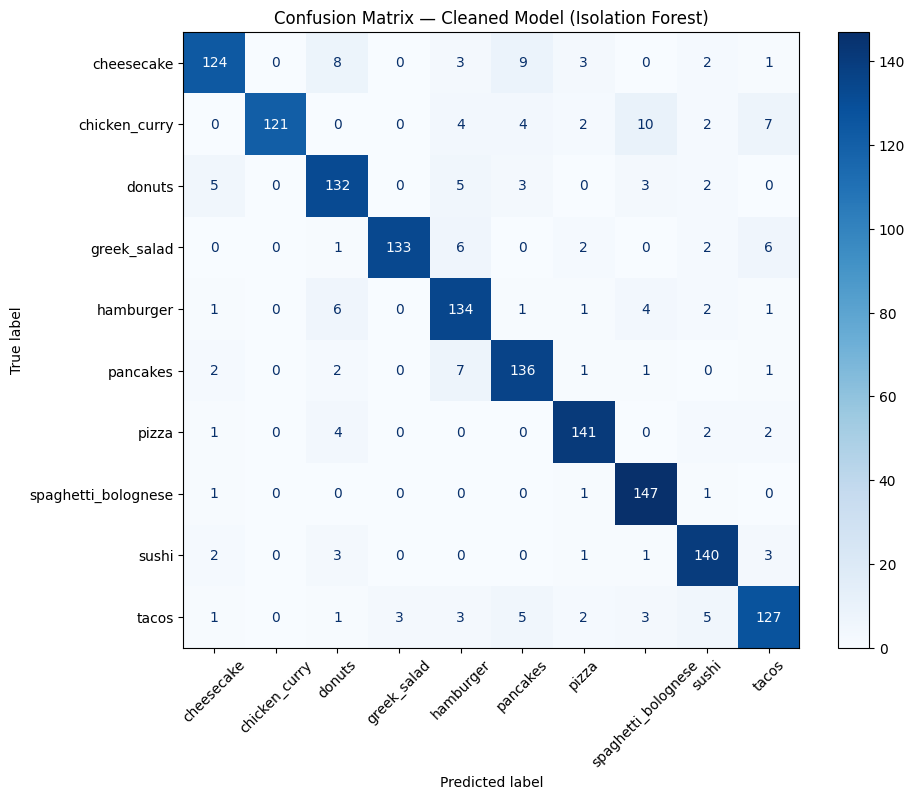

In [31]:
# Add cleaned model metrics
metrics_all.append(evaluate_metrics(cleaned_model, test_loader, name='Cleaned w/ IsolationForest'))

# Metrics Visualization
df_metrics = pd.DataFrame(metrics_all)
df_melt = df_metrics.melt(id_vars='Name', var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 6))
sns.barplot(data=df_melt, x='Metric', y='Score', hue='Name')
plt.title('Classification Metrics (Including Isolation Forest Defense)')
plt.ylim(0, 1.05)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Confusion Matrix for cleaned model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = cleaned_model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix — Cleaned Model (Isolation Forest)")
plt.show()

### Detailed Comparison

Delta from Clean Model:


,Accuracy,Precision,Recall,F1-score
Name,,,,
Clean,0.000000,0.000000,0.000000,0.000000
Poisoned,-0.093750,-0.063492,-0.068254,-0.066648
FGSM ε=0.01,-0.831250,-0.177532,-0.231143,-0.240379
FGSM ε=0.05,-0.856250,-0.183333,-0.243143,-0.250533
FGSM ε=0.1,-0.793750,-0.144102,-0.234180,-0.232292
DeepFool,-0.756250,-0.206404,-0.241810,-0.244978
Cleaned w/ IsolationForest,-0.010000,0.608418,0.632857,0.619313


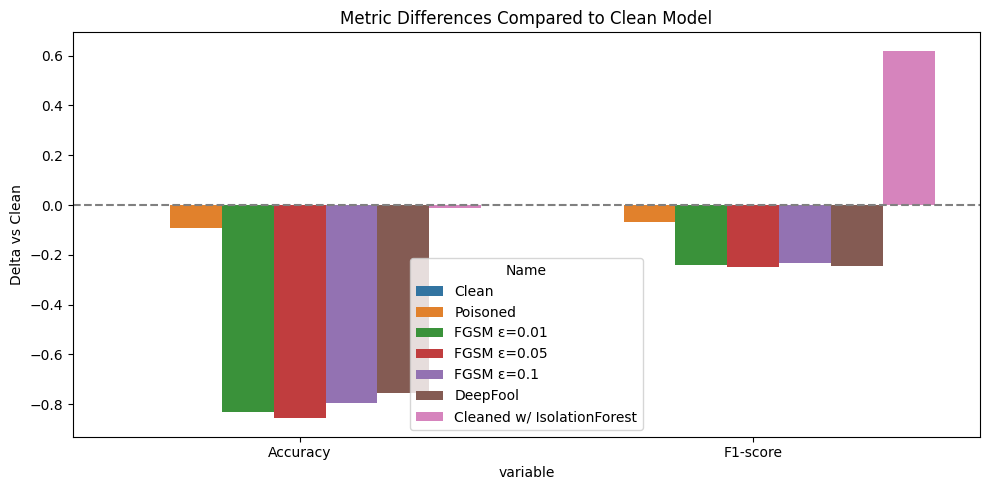

In [32]:
# Convert to DataFrame
df_metrics = pd.DataFrame(metrics_all).set_index('Name')

baseline = df_metrics.loc['Clean']

# Calculate deltas
df_deltas = df_metrics.copy()
for name in df_deltas.index:
    df_deltas.loc[name] = df_metrics.loc[name] - baseline

# Visualization
print("Delta from Clean Model:")
display(df_deltas.style.background_gradient(cmap='RdYlGn', axis=1))

# Accuracy and F1
df_deltas_subset = df_deltas[['Accuracy', 'F1-score']].reset_index().melt(id_vars='Name')

plt.figure(figsize=(10, 5))
sns.barplot(data=df_deltas_subset, x='variable', y='value', hue='Name')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Metric Differences Compared to Clean Model')
plt.ylabel('Delta vs Clean')
plt.tight_layout()
plt.show()

## 2. Adversarial Training (using FGSM)

In [35]:
# Generators
class MixedAdversarialDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset, model, epsilon=0.02, ratio=0.5):
        self.clean_dataset = base_dataset
        self.model = model
        self.epsilon = epsilon
        self.ratio = ratio
        self.model.eval()

    def __len__(self):
        return len(self.clean_dataset)

    def __getitem__(self, idx):
        image, label = self.clean_dataset[idx]
        if torch.rand(1).item() < self.ratio:
            image = image.unsqueeze(0).to(device)
            label_tensor = torch.tensor(label).unsqueeze(0).to(device)

            image.requires_grad = True
            output = self.model(image)
            loss = criterion(output, label_tensor)
            self.model.zero_grad()
            loss.backward()
            data_grad = image.grad.data

            image = fgsm_attack(image, self.epsilon, data_grad)
            image = image.squeeze(0).detach().cpu()
        return image, label

# Create dataset and loaders and use poisoned_model in attacks generation
adv_train_dataset = MixedAdversarialDataset(poisoned_dataset, poisoned_model, epsilon=0.02, ratio=0.5)
adv_train_loader = DataLoader(adv_train_dataset, batch_size=32, shuffle=True)

In [37]:
# Training
adv_model = models.resnet50(pretrained=True)
adv_model.fc = nn.Linear(adv_model.fc.in_features, len(selected_classes))
adv_model = adv_model.to(device)

optimizer = optim.Adam(adv_model.parameters(), lr=1e-4)

for epoch in range(5):
    print(f"\n[Adversarial Training] Epoch {epoch+1}")
    train_loss, train_acc = train_one_epoch(adv_model, adv_train_loader, criterion, optimizer)
    val_loss, val_acc = evaluate(adv_model, val_loader, criterion)
    print(f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

torch.save(adv_model.state_dict(), 'adv_model.pth')


[Adversarial Training] Epoch 1


Validation: 100%|███| 48/48 [01:06<00:00,  1.38s/it]


Train Acc: 0.5969, Val Acc: 0.8046

[Adversarial Training] Epoch 2


Validation: 100%|███| 48/48 [01:04<00:00,  1.35s/it]


Train Acc: 0.7199, Val Acc: 0.8126

[Adversarial Training] Epoch 3


Validation: 100%|███| 48/48 [01:03<00:00,  1.32s/it]


Train Acc: 0.7549, Val Acc: 0.8377

[Adversarial Training] Epoch 4


Validation: 100%|███| 48/48 [01:03<00:00,  1.32s/it]


Train Acc: 0.7884, Val Acc: 0.8397

[Adversarial Training] Epoch 5


Validation: 100%|███| 48/48 [01:03<00:00,  1.32s/it]


Train Acc: 0.8000, Val Acc: 0.8179



Evaluating: Adversarial Training 
Processing batches...
  → Batch 1
  → Batch 2
  → Batch 3
  → Batch 4
  → Batch 5
  → Batch 6
  → Batch 7
  → Batch 8
  → Batch 9
  → Batch 10
  → Batch 11
  → Batch 12
  → Batch 13
  → Batch 14
  → Batch 15
  → Batch 16
  → Batch 17
  → Batch 18
  → Batch 19
  → Batch 20
  → Batch 21
  → Batch 22
  → Batch 23
  → Batch 24
  → Batch 25
  → Batch 26
  → Batch 27
  → Batch 28
  → Batch 29
  → Batch 30
  → Batch 31
  → Batch 32
  → Batch 33
  → Batch 34
  → Batch 35
  → Batch 36
  → Batch 37
  → Batch 38
  → Batch 39
  → Batch 40
  → Batch 41
  → Batch 42
  → Batch 43
  → Batch 44
  → Batch 45
  → Batch 46
  → Batch 47
Done: Adversarial Training



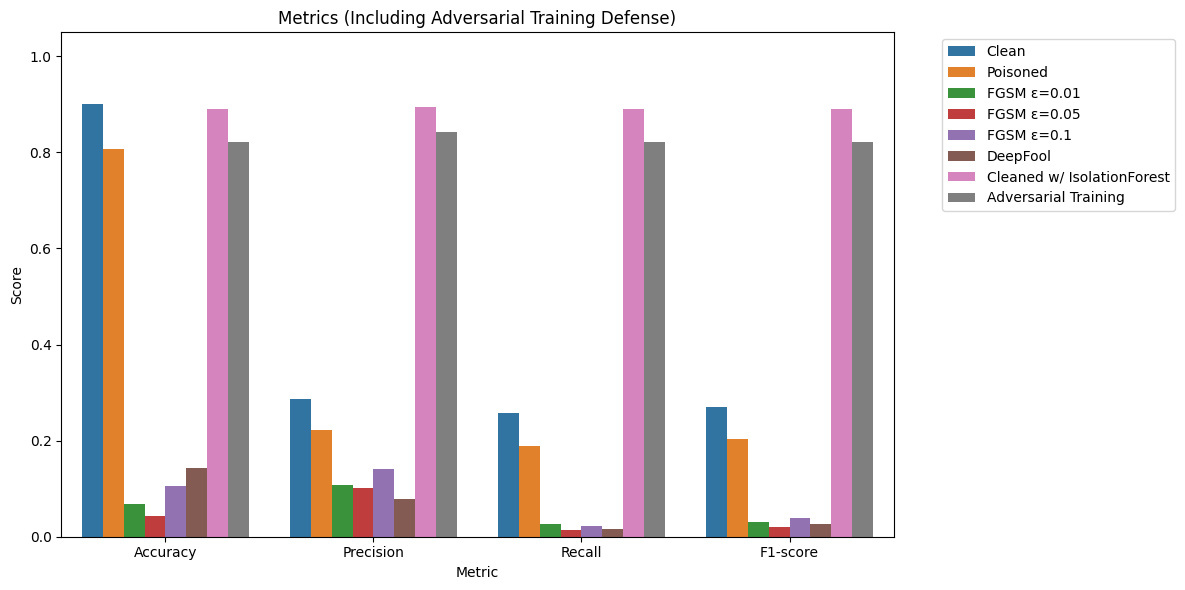

In [38]:
# Evaluation and comparison
metrics_all.append(evaluate_metrics(adv_model, test_loader, name='Adversarial Training'))

# new table and plots
df_metrics = pd.DataFrame(metrics_all)
df_melt = df_metrics.melt(id_vars='Name', var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 6))
sns.barplot(data=df_melt, x='Metric', y='Score', hue='Name')
plt.title('Metrics (Including Adversarial Training Defense)')
plt.ylim(0, 1.05)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Attack Defended Model with FGSM and DeepFool


Evaluating: AdvTr + FGSM ε=0.05 (FGSM ε=0.05)
Processing batches...
  → Batch 1
  → Batch 2
  → Batch 3
  → Batch 4
  → Batch 5
Done: AdvTr + FGSM ε=0.05


Evaluating: AdvTr + DeepFool 
Processing batches...
  → Batch 1
     Running DeepFool on batch 1...
  → Batch 2
     Running DeepFool on batch 2...
  → Batch 3
     Running DeepFool on batch 3...
  → Batch 4
     Running DeepFool on batch 4...
  → Batch 5
     Running DeepFool on batch 5...
Done: AdvTr + DeepFool



KeyError: '`Styler.apply` and `.map` are not compatible with non-unique index or columns.'

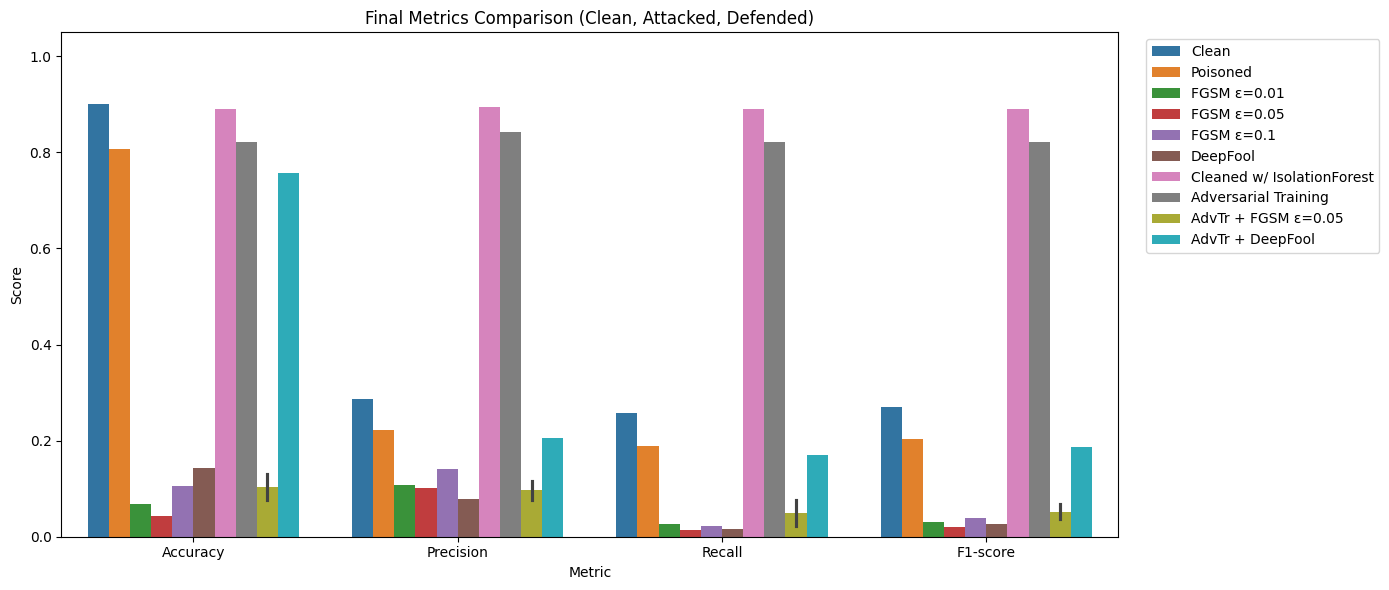

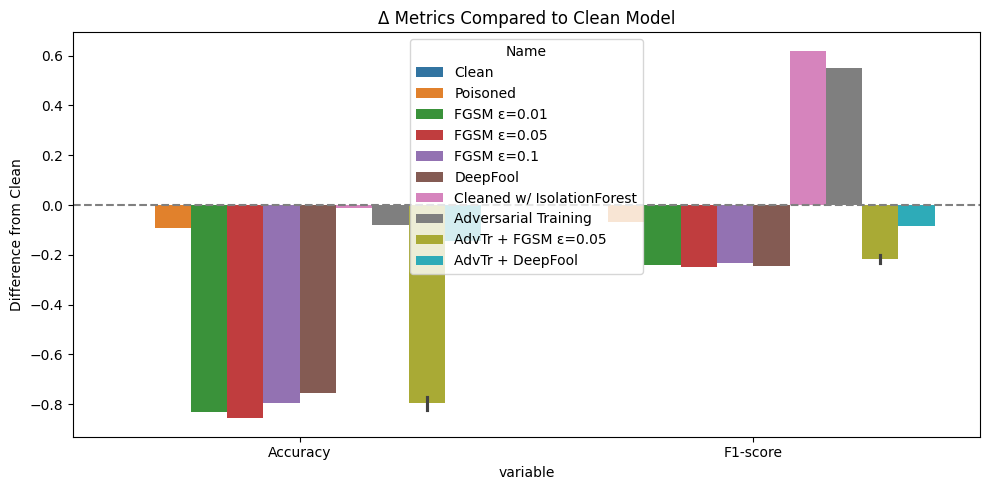

In [40]:
# FGSM (ε=0.05)
metrics_all.append(
    evaluate_metrics(
        adv_model, 
        test_loader, 
        attack='fgsm', 
        epsilon=0.05, 
        name='AdvTr + FGSM ε=0.05',
        max_batches=5
    )
)

# DeepFool (limited to 5 batches)
metrics_all.append(
    evaluate_metrics(
        adv_model, 
        test_loader, 
        attack='deepfool', 
        name='AdvTr + DeepFool',
        max_batches=5
    )
)

# All metrics
df_metrics = pd.DataFrame(metrics_all).set_index('Name')
display(df_metrics.style.highlight_max(axis=0, color='lightgreen'))

# Visualization
df_melt = df_metrics.reset_index().melt(id_vars='Name', var_name='Metric', value_name='Score')

plt.figure(figsize=(14, 6))
sns.barplot(data=df_melt, x='Metric', y='Score', hue='Name')
plt.title('Final Metrics Comparison (Clean, Attacked, Defended)')
plt.xticks(rotation=0)
plt.ylim(0, 1.05)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

# delta plot
baseline = df_metrics.loc['Clean']
df_deltas = df_metrics.subtract(baseline)

df_deltas_subset = df_deltas[['Accuracy', 'F1-score']].reset_index().melt(id_vars='Name')

plt.figure(figsize=(10, 5))
sns.barplot(data=df_deltas_subset, x='variable', y='value', hue='Name')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Δ Metrics Compared to Clean Model')
plt.ylabel('Difference from Clean')
plt.tight_layout()
plt.show()

In [46]:
df_metrics = df_metrics.reset_index(drop=True)
df_metrics.index = [f'Entry_{i}' for i in range(len(df_metrics))]

display(df_metrics.style.highlight_max(axis=0, color='lightgreen'))

,Accuracy,Precision,Recall,F1-score
Entry_0,0.900000,0.285714,0.257143,0.270677
Entry_1,0.806250,0.222222,0.188889,0.204029
Entry_2,0.068750,0.108182,0.026000,0.030298
Entry_3,0.043750,0.102381,0.014000,0.020143
Entry_4,0.106250,0.141612,0.022963,0.038385
Entry_5,0.143750,0.079310,0.015333,0.025698
Entry_6,0.890000,0.894133,0.890000,0.889990
Entry_7,0.820667,0.843300,0.820667,0.821222
Entry_8,0.077333,0.076193,0.077333,0.068929
Entry_9,0.131250,0.116667,0.023333,0.036029


# Final Visualizations

,Name,Accuracy,Precision,Recall,F1-score
0,Clean,0.900000,0.285714,0.257143,0.270677
1,Poisoned,0.806250,0.222222,0.188889,0.204029
2,FGSM ε=0.01,0.068750,0.108182,0.026000,0.030298
3,FGSM ε=0.05,0.043750,0.102381,0.014000,0.020143
4,FGSM ε=0.1,0.106250,0.141612,0.022963,0.038385
5,DeepFool,0.143750,0.079310,0.015333,0.025698
6,Cleaned w/ IsolationForest,0.890000,0.894133,0.890000,0.889990
7,Adversarial Training,0.820667,0.843300,0.820667,0.821222
8,AdvTr + FGSM ε=0.05,0.077333,0.076193,0.077333,0.068929
9,AdvTr + FGSM ε=0.05,0.131250,0.116667,0.023333,0.036029


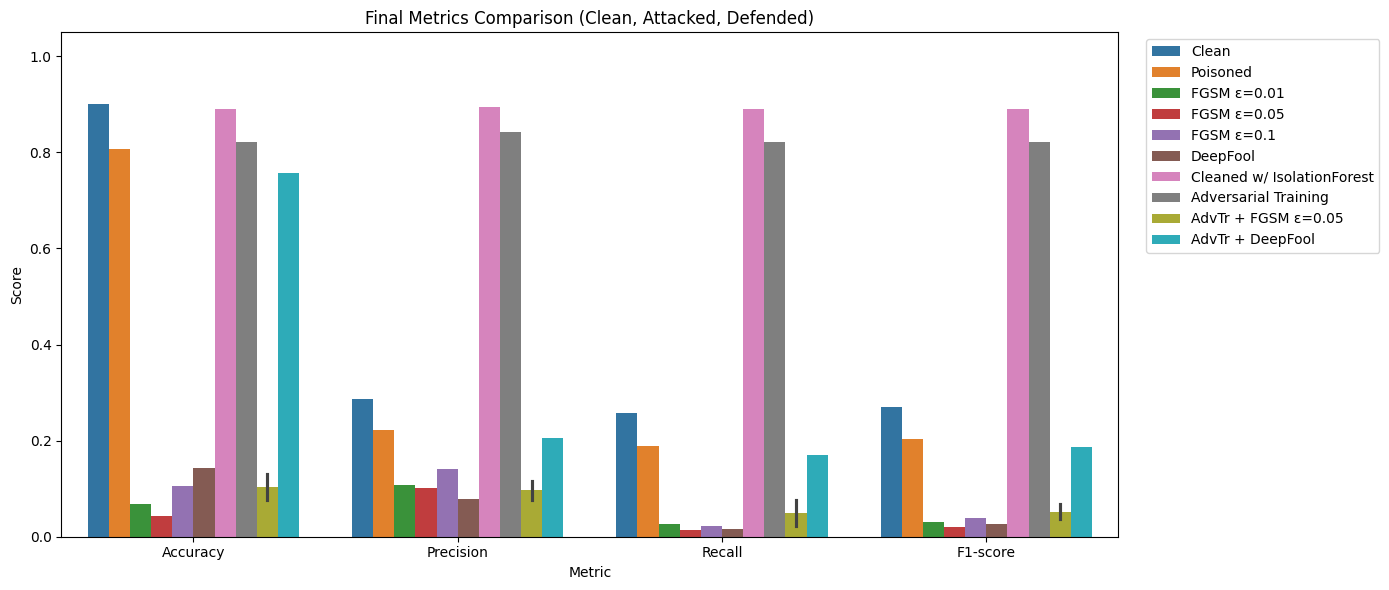

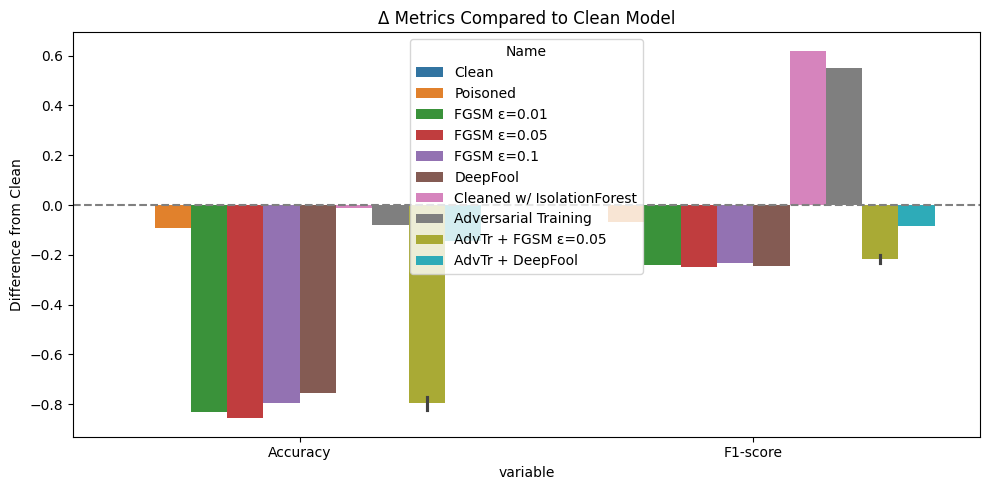

In [47]:
# All metrics
df_metrics = pd.DataFrame(metrics_all)

# drop index
df_styled = df_metrics.copy()
try:
    display(df_styled.style.highlight_max(axis=0, color='lightgreen'))
except Exception as e:
    print("Could not display styled table:", e)
    display(df_metrics)

# Visualization
df_melt = df_metrics.melt(id_vars='Name', var_name='Metric', value_name='Score')

plt.figure(figsize=(14, 6))
sns.barplot(data=df_melt, x='Metric', y='Score', hue='Name')
plt.title('Final Metrics Comparison (Clean, Attacked, Defended)')
plt.xticks(rotation=0)
plt.ylim(0, 1.05)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Delta from Clean
df_metrics = df_metrics.set_index('Name')
df_deltas = df_metrics.subtract(df_metrics.loc['Clean'])

df_deltas_subset = df_deltas[['Accuracy', 'F1-score']].reset_index().melt(id_vars='Name')

plt.figure(figsize=(10, 5))
sns.barplot(data=df_deltas_subset, x='variable', y='value', hue='Name')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Δ Metrics Compared to Clean Model')
plt.ylabel('Difference from Clean')
plt.tight_layout()
plt.show()

FGSM ε=0.0: 100%|███| 47/47 [01:44<00:00,  2.23s/it]


FGSM ε=0.0 → Accuracy: 0.8880


FGSM ε=0.01: 100%|██| 47/47 [01:43<00:00,  2.20s/it]


FGSM ε=0.01 → Accuracy: 0.1413


FGSM ε=0.05: 100%|██| 47/47 [01:43<00:00,  2.20s/it]


FGSM ε=0.05 → Accuracy: 0.0647


FGSM ε=0.1: 100%|███| 47/47 [01:43<00:00,  2.20s/it]

FGSM ε=0.1 → Accuracy: 0.0867


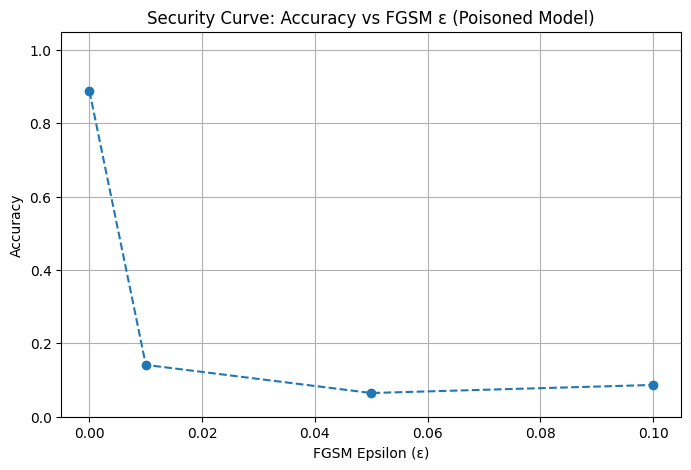

In [41]:
# Security Curve: Accuracy vs FGSM ε
epsilons = [0.0, 0.01, 0.05, 0.1]
accuracies = []

for eps in epsilons:
    acc = evaluate_fgsm(poisoned_model, test_loader, epsilon=eps)
    accuracies.append(acc)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(epsilons, accuracies, marker='o', linestyle='--')
plt.title('Security Curve: Accuracy vs FGSM ε (Poisoned Model)')
plt.xlabel('FGSM Epsilon (ε)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.ylim(0, 1.05)
plt.show()

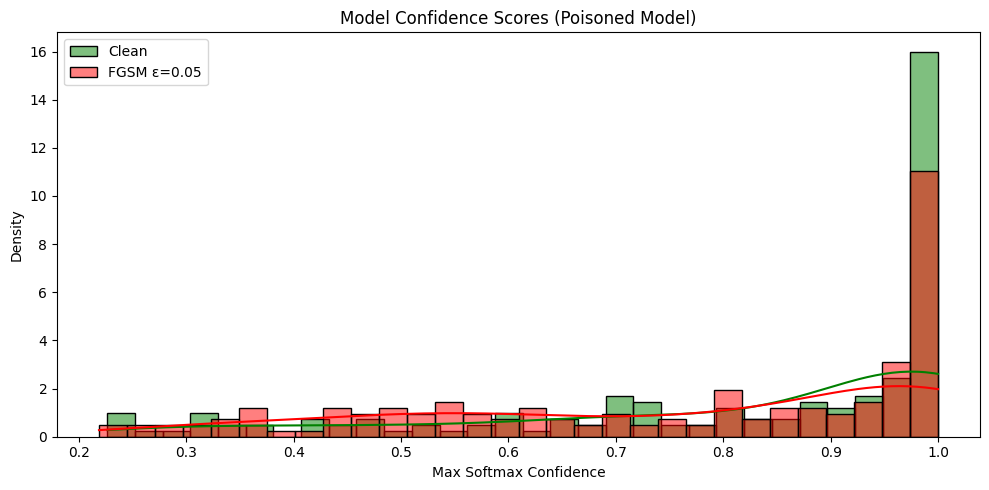

In [43]:
# Confidence histograms for clean and FGSM-attacked data
def get_confidence_scores(model, dataloader, attack=None, epsilon=0.05, max_batches=5):
    model.eval()
    confidences = []

    for batch_idx, (images, labels) in enumerate(dataloader):
        if batch_idx >= max_batches:
            break
        images, labels = images.to(device), labels.to(device)

        if attack == 'fgsm':
            images.requires_grad = True
            outputs = model(images)
            loss = criterion(outputs, labels)
            model.zero_grad()
            loss.backward()
            data_grad = images.grad.data
            images = fgsm_attack(images, epsilon, data_grad)

        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        max_conf = probs.max(dim=1)[0]
        confidences.extend(max_conf.detach().cpu().numpy())

    return confidences

# Collect
conf_clean = get_confidence_scores(poisoned_model, test_loader, attack=None)
conf_fgsm  = get_confidence_scores(poisoned_model, test_loader, attack='fgsm', epsilon=0.05)

# Plot
plt.figure(figsize=(10, 5))
sns.histplot(conf_clean, bins=30, color='green', label='Clean', stat='density', kde=True)
sns.histplot(conf_fgsm,  bins=30, color='red', label='FGSM ε=0.05', stat='density', kde=True)
plt.title("Model Confidence Scores (Poisoned Model)")
plt.xlabel("Max Softmax Confidence")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

In [48]:
# save to CSV
df_metrics.to_csv("final_metrics.csv")